### Table of Contents
[Introduction](#intro)  
[Code Flow](#code)  
[Model Architecture](#model)  
[Results](#results)  
[Further/Possible Improvements](#improvements)  
[References](#reference)

### <a name='intro'>CNN+BiLSTM hybrid approach to Part-of-Speech(PoS) tagging to predict and restore punctuations to sentences</a>

The prevalent take on PoS problems have been to use BiLSTM or LSTM models due to their ability to capture and learn dependency information of sentences which are then used to make predictions.

This project intends to combine CNN with BiLSTM. Making use of CNNs' ability to capture word and morphological of sentences and forwarding them to the BiLSTM.

Outcome is to produce a hybrid model which outperforms a BiLSTM model.

#### <a name='code'>Code flow</a>

General code flow:

1. Import packages and dependencies required for the application
2. Load and process Ted Talks dataset to generate the corresponding labels  
3. Remove punctuations from dataset to remove bias  
4. Build vocabulary mappings of the dataset words and labels  
5. Tokenize dataset and labels based on mappings
6. Pad sequences and labels in dataset to maximum sequence length
7. One-hot encode labels as data is not ordinal
8. Split dataset into training and testing sets
9. Construct hybrid model
10. Feed training data into model with 30% of it used as validation
11. Load and process Glove embeddings to extract weight matrix based on unique words in dataset
12. Fit and train model with early stopping and checkpoint save of best results
13. Save image of model architecture
14. Delete current model and load saved model with best results
15. Retrieve a sample of testing data and make a prediction on it
16. Restore and print out results of prediction
17. Make predictions using testing set and construct a Confusion Matrix & Classification Report from it to evaluate model
18. Print out Precision, Recall and F1-Scores for testing set

#### Import required packages

In [1]:
# Set random seed
from numpy.random import seed
seed(50)
from tensorflow import set_random_seed
set_random_seed(50)

# Import required packages and dependencies
import io, json, keras, string, itertools, random, time, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, \
pandas as pd
from string import punctuation
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.initializers import glorot_uniform, random_uniform
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, \
Dropout, Input, concatenate, Reshape
from keras import regularizers
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


#### Define model parameters

In [2]:
# Set model parameters
# Dimension of the embedding layer, must match that of the word vectors
embed_dim = 300

# Maximum sequence length, how long each sentence/sequence should be
max_seq_len = 128

# Dropout are
drop_prob = 0.3

# Number of filters for each CNN layer 
filter_sizes = [64,64,64]

# Kernel size for each CNN layer
kernels = [3,5,7]

# Weights and bias initialization for each CNN layer
kernel_weight = glorot_uniform()
bias = random_uniform()

# Regularization for each CNN layer
# kernel_reg = regularizers.l2(l=0.0001)
kernel_reg = None

# Embed trainable
trainable = False

# Number of hidden units for Dense layer
lstm_hidden = 1024

# Number of hidden units for BiLSTM layer
lstm_hidden_2 = 1024

# Learning rate for Adam optimizer
adam_lr = 0.001

# Batch size
batch_size = 64

# Number of epochs to train for
epochs = 30

# Portion of training data to be used for validation
valid_split = 0.3

# Define padding for CNN layers
cnn_padding = 'same'

# Define activation function for CNN layers
cnn_activation = 'relu'

# Define activation function for dense layer
dense_activation = 'relu'

# Define early stop parameters
monitor = 'val_loss'
patience = 2

# Define modelcheckpoint parameters
save_best_only=True

# Define padding type
seq_lab_padding = 'post'

#### Define miscellaneous settings 

In [3]:
# Dataset filename, change this variable to switch datasets
dataset_name = 'ted_data'

# train, validation dataset split ratio
split_rat = 0.8

#### Define custom functions

In [4]:
# Define custom functions
def plot_confusion_matrix(cm, dataset_type, normalize=False, cmap=plt.cm.Blues):
    '''
    Description: 
        - Prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    Args:
        - cm: Confusion Matrix
        - classes: Names of classes
        - normalize: Whether to or to not normal values in Confusion Matrix
        - cmap: Plot color
    '''

    # Check if normalize is true or false
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("****Normalized confusion matrix:****")
    else:
        print('Confusion matrix, without normalization')
    
    # Define class names
    if dataset_type == 'mge' or dataset_type == 'MGE':
        classes = ['Pad', 'NA', 'Period', 'Comma', 'Question', 'Exclaim', 'Ellipsis']        
    else:
        classes = ['Pad', 'NA', 'Comma', 'Period', 'Question', 'Exclaim', 'Ellipsis']      
        
    # Format axis and plot Confusion Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(dataset_type+' Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.show()
#     plt.savefig('test1.jpg')

def get_labels(seq):
    '''
    Description: 
        - Creates a sequence of labels based on the input sequence

    Args:
        - seq: Input sequence
    
    Returns:
        - labels_seq: Sequence labels
    '''
    
    labels_seq = []
    seq = seq.split()
    for i in range(len(seq)):
        if '...' in seq[i]:
            labels_seq.append('<3-dots>')
        elif ',' in seq[i]:
            labels_seq.append('<comma>')
        elif '.' in seq[i]:
            labels_seq.append('<period>')
        elif '?' in seq[i]:
            labels_seq.append('<question>')
        elif '!' in seq[i]:
            labels_seq.append('<exclaim>')
        else:
            labels_seq.append('<na>')
    return labels_seq

def process_dataset(dataset_name):
    '''
    Description:
        - Process the Ted Talks dataset
        - Processed data and labels are written to the processed folder
        
    Args:
        - dataset_name: Name of dataset file to be processed
    '''
    data = open('./data/raw/'+dataset_name, 'r', encoding='utf-8').read()
    
    # Convert all characters to lowercase
    data = data.lower()

    # Look-up table to remove punctuations from data
    table = str.maketrans('', '', punctuation)

    # Define and remove characters and bracketed actions
    replace = ['♫', '♪', '–', '…', '(applause)', '(laughter)']
    for i in range(len(replace)):
        data = data.replace(replace[i], ' ')

    # Split dataset by sentences
    data_split = data.split('\n')
    print('Pre number of '+dataset_name+' sentences: \t{}'.format(len(data_split)))
    print('\n')
    
    # Get longest sentence in dataset and its index
    print(max(enumerate(data_split), key=lambda x: len(x[1])))
    print('\n')
    print('Length of longest '+dataset_name+' sentence: \t{}'.format(len(max(data_split, key=len))))

    # Clean and split the longest sentence into multiple ones based on full-stops
    data_split[185073] = data_split[185073].replace(',', ', ')
    data_split[185073] = data_split[185073].replace('.', '.\n')
    long_sent = data_split[185073].split('\n')

    # Check number of sentences from chunking longest sentence
    print('Chunked longest '+dataset_name+' sentence: \t{}'.format(len(long_sent)))

    # Remove longest sentence at index 185703
    del data_split[185073]

    # Add chunked sentences back to dataset
    for x in long_sent:
        data_split.append(x)

    # Check length of dataset after addition
    print('Post number of '+dataset_name+' sentences: \t{}'.format(len(data_split)))
    print('\n')

    # Remove empty rows
    data_split = data_split[:238003]

    # Check last sentence of dataset
    print('Last Sentence of '+dataset_name+' dataset: {}'.format(data_split[-1]))
    print('\n')

    # Get corresponding labels for dataset
    process_labels = [get_labels(seq) for seq in data_split]
    process_labels = [' '.join(seq) for seq in process_labels]

    # Remove all punctuations from dataset
    sequences = [seq.translate(table) for seq in data_split]

    # Combined sentences back into a single piece for Counter
    combined_sequences = ' '.join(sequences)

    # Check if there are additional characters to remove
    print(Counter(combined_sequences))
    print('\n')

    # Get all words in the dataset
    words = combined_sequences.split()

    # Save inputs and labels for loading
    with open('./data/processed/'+dataset_name+'_processed_inputs', 'w', encoding='utf-8') as f:
        for x in sequences:
            f.write(x+'\n')
    with open('./data/processed/'+dataset_name+'_processed_labels', 'w', encoding='utf-8') as f:
        for x in process_labels:
            f.write(x+'\n')

    # Check number of sequences and labels
    print('Number of '+dataset_name+' sequences after processing: \t{}'.format(len(sequences)))
    print('Number of '+dataset_name+' labels after processing: \t{}'.format(len(process_labels)))
        
def load_processed_dataset(dataset_name):
    '''
    Description:
        - Loads processed dataset (Data and labels)
        - Dataset(s) must be present in the processed folder
        
    Args:
        - dataset_name: Name of data and labels file to be loaded
        
    Returns:
        - data_split: Processed data
        - y_labels: Processed labels
    '''
    # Load and process input/label data
    data = open('./data/processed/'+dataset_name+'_processed_inputs', 'r', encoding='utf-8').read()
    data = data.lower()
    data_split = data.split('\n')
    data_split = data_split[:-1]

    # Load processed labels
    y_labels = open('./data/processed/'+dataset_name+'_processed_labels', 'r', encoding='utf-8').read()
    y_labels = y_labels.split('\n')
    y_labels = y_labels[:-1]
    
    return data_split, y_labels    

def tokenize_data(data, labels, dataset_name):
    '''
    Description:
        - Tokenize and pad data/labels into integer sequences
        - Labels will further be one-hot encoded
        - Json files mapping unique words and labels will also be written into the processed folder
        
    Args:
        - data: Input data
        - labels: Labels
        - dataset_name: Name of dataset
        
    Returns:
        - unique_vocab: Number of unique words
        - no_classes: Number of unique labels
        - pad_seq: Tokenized and padded input data
        - encoded_labels: One-hot encoded labels sequences
        - vocab_to_int: Mapping of unique words to integers
        - label_to_int: Mapping of unique labels to integers
    '''
    # Join all words in data into one
    all_data = ' '.join(data)
    # Get all words
    words = all_data.split()
        
    # Build words vocab
    words_in_vocab = Counter(words)
    vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

    # Skip most common word
    vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
    vocab_to_int['<pad>'] = 0  # The special value used for padding
    vocab_to_int['<oov>'] = 1  # The special value used for OOVs
    
    # Write vocab dictionaries to file
    with open('./data/processed/'+dataset_name+'_vocabs.json', 'w', encoding='utf-8') as fv:
        json.dump(vocab_to_int, fv, indent=4)
    
    # Check number of unique words
    unique_vocab = len(vocab_to_int)
    print('Number of unique words:', unique_vocab)
    print('\n')
    
    # Tokenize input sequences
    seq_int = []
    for seq in data:
        seq_int.append([vocab_to_int[word] for word in seq.split()])

    # Pad input sequences
    pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding=seq_lab_padding, value=0)

    # Check sample sequence
    print('Sample sequence:', data[-1])
    print('\n')
    print('Sample sequence:', pad_seq[-1])
    print('\n')
    
    # Join all labels into one
    all_labels = ' '.join(labels)
    # Get all labels
    labels_tag = all_labels.split()
    
    print('Labels: {}'.format(Counter(labels_tag)))
    
    # Build labels vocab
    labels_in_vocab = Counter(labels_tag)
    labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
    label_to_int = {t: i for i, t in enumerate(labels_vocab, 1)}
    label_to_int['<pad>'] = 0  # The special value used to padding #variable

    # Write labels dictionaries to file
    with open('./data/processed/'+dataset_name+'_labels.json', 'w', encoding='utf-8') as fl:
        json.dump(label_to_int, fl, indent=4)

    # Check label classes distribution
    no_classes = len(label_to_int)
    print('Class distribution:', Counter(labels_in_vocab))
    print('\n')

    # Check number of unique labels
    print('Number of unique labels:', no_classes)
    print(label_to_int)   
    print('\n')

    # Tokenize output labels
    lab_int = []
    for lab in labels:
        lab_int.append([label_to_int[word] for word in lab.split()])

    # Pad input labels
    pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding=seq_lab_padding, value=0)
    encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

    # Check sample label
    print('Sample label: \t{}'.format(pad_labels[-1]))
    print('\n')
    print('Encoded label: \t{}'.format(encoded_labels[-1]))
    print('\n')

    # Check that all sequences and labels are at max sequence length 
    assert len(pad_seq)==len(seq_int)
    assert len(pad_seq[0])==max_seq_len

    assert len(pad_labels)==len(lab_int)
    assert len(pad_labels[0])==max_seq_len
    print('Sequence and labels length check passed!')
    
    return unique_vocab, no_classes, pad_seq, encoded_labels, vocab_to_int, label_to_int

def split_data(pad_seq, encoded_labels, dataset_name):
    '''
    Description:
        - Splits tokenized data and labels into training and validation sets
        
    Args:
        - pad_seq: Toekenized input data sequences
        - encoded_labels: One-hot encoded labels sequences
        - dataset_name: Name of dataset
        
    Returns:
        - train_val_x: Training/validation input data
        - test_x: Testing input data
        - train_val_y: Training/validation labels
        - test_y: Testing labels
    '''
    # Ratio to split data and labels at
    split_index = int(split_rat*len(pad_seq))

    # Split data into training, validation, and test data (features and labels, x and y)
    train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
    train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

    # print out the shapes of your resultant feature data
    print('Training/Validation '+dataset_name+' Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
    print('Testing '+dataset_name+' Dataset: \t\t\t{}'.format(test_x.shape), len(test_y))
    
    return train_val_x, test_x, train_val_y, test_y

def set_callbacks(monitor, patience, dataset_name, save_best_only, batch_size):
    '''
    Descriptin:
        - Sets parameters for callbacks during training
        
    Args:
        - monitor: Metric to monitor during training for changes
        - patience: Number of epochs to keep training when there are no improvements
        - dataset_name: Name of dataset
        - save_best_only: Saves best training results
        - batch_size: Number of training data/labels per epoch
        
    Returns:
        - early_s: Early stopping callback
        - chkpt: Model checkpoint callback
        - tensor_b: Tensorboard callback
    '''
    early_s = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    chkpt = ModelCheckpoint(filepath='./models/'+dataset_name+'_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)
    tensor_b = TensorBoard(log_dir='./tf_logs/{}_model'.format(dataset_name, batch_size=batch_size, 
                        write_graph=False, histogram_freq=0))
    
    return early_s, chkpt, tensor_b

def create_model(max_seq_len, input_dim, output_dim, embed_weights, seq_len, trainable, drop_prob, lstm_hidden_2, 
                no_classes, model_type, **kwargs):
    '''
    Description: 
        - Constructs and compiles the CNN+BiLSTM model
    
    Args:
        - max_seq_len: Maximum sequence length of each sequence, defines input shape (None, 128)
        - input_dim: Size of vocabulary, number of unique words
        - output_dim: Dimension of the dense embedding (128, 300)
        - embed_weights: Pre-trained weights extracted from Glove embeddings
        - seq_len: Length of each input sequence
        - trainable: If the pre-trained weights can be trained
        - drop_prob: Dropout rate 
        - lstm_hidden_2: Number of hidden units for the BiLSTM layer
        - no_classes: Number of classes to predict for 
        - model_type: Hybrid, Baseline or MGE
        
    **kwargs(Arguements used when creating the Hybrid and MGE models):
        - lstm_hidden: Number of hidden units in Dense layer after CNN
        - filter_sizes: Filter sizes for each CNN layer
        - kernel_size: Kernel sizes for each CNN layer
        - kernel_reg: Kernel regularization
        - kernel_initializer: Kernel weights initialization (Glorot)
        - bias_initializer: Bias initialization for CNN layers
        - activation: Activation function for Dense layer
        - padding: Padding type for CNN layers
        
    Return: 
        - model: Compiled model
    '''
    embed_input = Input(shape=(max_seq_len,))

    # Add embedding layer using weights from glove
    embed = Embedding(input_dim=unique_vocab, output_dim=embed_dim, weights=[embed_matrix], 
                      input_length=seq_len, trainable=trainable)(embed_input) #104910 * 300
    
    # Add dropout to embedding layer
    embed = Dropout(rate=drop_prob)(embed)
    
    if model_type == 'baseline':
        blstm_outputs = Bidirectional(LSTM(lstm_hidden_2, return_sequences=True))(embed)
        blstm_outputs = Dropout(rate=drop_prob)(blstm_outputs)
        output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)
    else:        
        cnn_outputs = []
        for i in range(len(filter_sizes)):
            # Add conv1d layer
            out_i = Conv1D(filters=filter_sizes[i], kernel_initializer=kernel_weight, bias_initializer=bias, 
                              kernel_size=kernels[i], kernel_regularizer=kernel_reg, activation=cnn_activation, 
                              padding=cnn_padding, strides=1)(embed)
            cnn_outputs.append(out_i)

        cnn_outputs = concatenate(cnn_outputs, axis=-1)
        cnn_outputs = Dropout(rate=drop_prob)(cnn_outputs)
        cnn_outputs = Reshape((-1, np.sum(filter_sizes)))(cnn_outputs)

        dense = Dense(lstm_hidden, activation=dense_activation)(cnn_outputs)
        dense = Dropout(rate=drop_prob)(dense)

        blstm_outputs = Bidirectional(LSTM(lstm_hidden_2, return_sequences=True))(dense)

        blstm_outputs = Dropout(rate=drop_prob)(blstm_outputs)

        output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)

    model = Model(inputs=[embed_input], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
              metrics=['accuracy'])
    
    return model

def plot_train_hist(model):
    '''
    Description:
        - Plots and prints monitored training metrics
        
    Args:
        - model: Trained model
    '''
    training_accuracy = model.history['acc']
    test_accuracy = model.history['val_acc']
    
    # Create count of the number of epochs
    epoch_count = range(1, len(training_accuracy) + 1)

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.show()

# def get_results(model, test_x, test_y, dataset_type): 
def get_results(model, test_x, test_y): 
    '''
    Description:
        - Generates Classification Reports and Confusion Matrices using trained models and their corresponding test
          data
          
    Args:
        - model: Trained model
        - test_x: Testing data
        - test_y: Testing labels (True labels)
        - dataset_type: Dataset type (Hybrid, Baseline or, MGE)
        
    Returns:
        - con_matrix: Confusion Matrix
        - class_rept_dict: Classification Report in dictionary form
    '''
#     if dataset_type == 'mge' or dataset_type == 'MGE':
#         target_names = ['Pad', 'NA', 'Period', 'Comma', 'Question', 'Exclaim', 'Ellipsis']
#     else:
#         target_names = ['Pad', 'NA', 'Comma', 'Period', 'Question', 'Exclaim', 'Ellipsis']   
        
    predict = model.predict(test_x)
    output_pred = [np.argmax(x, axis=1) for x in predict]
    output_pred = np.concatenate(output_pred, axis=0)

    y_ = [np.argmax(y, axis=1) for y in test_y]
    y_ = np.concatenate(y_, axis=0)
    
    con_matrix = confusion_matrix(y_true=y_, y_pred=output_pred)
    
#     class_rept = classification_report(y_true=y_, y_pred=output_pred, target_names=target_names)
    
    class_rept_dict = classification_report(y_true=y_, y_pred=output_pred, output_dict=True)  
    
#     return con_matrix, class_rept, class_rept_dict
    return con_matrix, class_rept_dict

def get_df(class_rept_dict, dataset_type):
    '''
    Description:
        - Converts the Classification Report dictionary into a Pandas DataFrame which can be used to display in a table format
        
    Args:
        - class_rept_dict: Dictionary of the Classification Report
        - dataset_type: Type of dataset the report was processed on
        
    Returns:
        - df: Converted dataframe with entries rounded to 2 decimal places
    '''
    precision = []
    recall = []
    f1 = []
    support = []

    data = {'precision': precision,
           'recall': recall,
           'f1-score': f1,
           'support': support}
    
    for idx, values in enumerate(class_rept_dict.items()):
        precision.append(values[1]['precision'])
        recall.append(values[1]['recall'])
        f1.append(values[1]['f1-score'])
        support.append(values[1]['support'])
    
    df = pd.DataFrame.from_dict(data)
    if dataset_type == 'MGE' or dataset_type == 'mge':
        df.rename(index={0:'Pad', 1:'NA', 2:'Period', 3:'Comma', 4:'Question', 5:'Exclaim', 6:'Ellipsis', 
                         7:'micro avg', 8:'macro avg', 9:'weighted avg'}, inplace=True)
    else:
        df.rename(index={0:'Pad', 1:'NA', 2:'Comma', 3:'Period', 4:'Question', 5:'Exclaim', 6:'Ellipsis',
                         7:'micro avg', 8:'macro avg', 9:'weighted avg'}, inplace=True)

    return df.round(2)
    
def make_prediction(model, test_seq, vocabs, labels, dataset_type, show_process=False):
    '''
    Description:
        - Generates a prediction using sample test data
        
    Args:
        - model: Trained model
        - test_seq: Sample test data sequence
        - vocabs: Words to integer mapping of dataset
        - labels: labels to integer mapping of dataset
        - dataset_type: Dataset type (Hybrid, Baseline or MGE)
        - show_process: Displays intermediate results prior to final (Default False)
    '''
    # Load a sample of test data
    test_data = test_seq

    # Restore tokenized test data back to normal sentence
    pred_x_seq = []
    for x in test_data:
        for value, index in vocabs.items():
            if x == index:
                pred_x_seq.append(value)

    # Get predicted output of test data (Make predictions)
    pred_expand = model.predict(np.expand_dims(test_data, axis=0))

    # Retrieve position of highest probability from predictions
    pred_y = []
    for y in pred_expand:
        pred_y.append(np.argmax(y, axis=1))

    # Restore tokenized labels
    pred_y_seq = []
    for x in pred_y:
        for y in x:
            for value, index in labels.items():
                if y == index:
                    pred_y_seq.append(value)

    # Restore punctuations and capitalization                
    combined = []
    if dataset_type == 'mge':
        for i in range(len(pred_x_seq)):
            if pred_y_seq[i] == '2':
                combined.append(str(pred_x_seq[i])+',')
            elif pred_y_seq[i] == '1':
                combined.append(str(pred_x_seq[i])+'.')
            elif pred_y_seq[i] == '3':
                combined.append(str(pred_x_seq[i])+'?')
            elif pred_y_seq[i] == '4':
                combined.append(str(pred_x_seq[i])+'!')
            elif pred_y_seq[i] == '5':
                combined.append(str(pred_x_seq[i])+'...')
            else:
                combined.append(str(pred_x_seq[i]))
    else:
        for i in range(len(pred_x_seq)):
            if pred_y_seq[i] == '<comma>':
                combined.append(str(pred_x_seq[i])+',')
            elif pred_y_seq[i] == '<period>':
                combined.append(str(pred_x_seq[i])+'.')
            elif pred_y_seq[i] == '<question>':
                combined.append(str(pred_x_seq[i])+'?')
            elif pred_y_seq[i] == '<exclaim>':
                combined.append(str(pred_x_seq[i])+'!')
            elif pred_y_seq[i] == '<3-dots>':
                combined.append(str(pred_x_seq[i])+'...')
            else:
                combined.append(str(pred_x_seq[i]))

    for i in range(len(combined)):
        if '.' in combined[i] or '?' in combined[i]:
            combined[i+1] = combined[i+1].capitalize()
        elif combined[i] == 'i':
            combined[i] = combined[i].capitalize()
        else:
            continue

    # Join predicted words back into a sequence
    combined = ' '.join(combined)
    combined = combined.replace('<pad>', '')
    
    if show_process:
        print('Predictions Index:')
        print(pred_y)
        print('\n')
        print('Prediction sequence:')
        print(' '.join(pred_x_seq))
        print('\n')
        print('Prediction output:')
        print(' '.join(pred_y_seq))
        print('\n')
        print('Combined prediction:')
        print(combined[0].capitalize()+combined[1:].replace('ive', "I've"))
    else:
        print('Combined prediction:')
        print(combined[0].capitalize()+combined[1:].replace('ive', "I've"))

#### Load and process Ted Talks dataset. Splits data into training and validation sets

In [5]:
# Load custom dataset and labels (Applies to hybrid and baseline models)
process_dataset(dataset_name)
custom_data, custom_labels = load_processed_dataset(dataset_name)
unique_vocab, no_classes, pad_seq, encoded_labels, vocab_to_int, label_to_int = tokenize_data(data=custom_data, 
                                                                                              labels=custom_labels, 
                                                                                              dataset_name=dataset_name)

# Split custom dataset into training and validation
train_val_x, test_x, train_val_y, test_y = split_data(pad_seq, encoded_labels, dataset_name=dataset_name)

Pre number of ted_data sentences: 	237986


(185073, '  and this is more fun.so this last one is called "the sunshine kid."thank you very much for listening.old man sunshine was proud of his sun,and it brightened his day to see his little boy run,not because of what he’d done, nor the problems overcome,but that despite that his disposition remained a sunny one.it hadn’t always been like this.there’d been times when he’d tried to hide his brightness,you see, every star hits periods of hardship,it takes a brighter light to inspire them through the darkness.if we go back to when he was born in a nebula,we know that he never was thought of as regular,because he had a flair about him,to say the midas touch is wrongbut all he went near seemed to turn a little bronze,yes this sun was loved by some more than others,it was a case of joseph and his dreamcoat and his brothersbecause standing out from the crowd had its pros and its cons,and jealousy created enemies in those he outshonesuch as the 

Training/Validation ted_data Dataset: 	(190402, 128) 190402
Testing ted_data Dataset: 			(47601, 128) 47601


#### Load MGE dataset. Splits data into training and validation sets

In [6]:
# Load MGE dataset and labels
mge_data, mge_labels = load_processed_dataset('mge')
mge_unique_vocab, mge_no_classes, mge_pad_seq, mge_encoded_labels, mge_vocab_to_int, mge_label_to_int =  \
                                                tokenize_data(data=mge_data, labels=mge_labels, dataset_name='mge')

# Split MGE dataset into training and validation
mge_train_val_x, mge_test_x, mge_train_val_y, mge_test_y = split_data(mge_pad_seq, mge_encoded_labels, dataset_name='mge')

Number of unique words: 76055


Sample sequence: what do you miss of your old life


Sample sequence: [ 23  29   6 561   7  42 190 197   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


Labels: Counter({'0': 5722741, '1': 582004, '2': 384732, '3': 109757, '4': 71598, '5': 30607})
Class distribution: Counter({'0': 5722741, '1': 582004, '2': 384732, '3': 109757, '4': 71598, '5': 30607})


Number of unique labels: 7
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '<pad>': 0}


Sample label: 	[1 1 1 1 1 1 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

#### Load and process Glove embeddings

In [8]:
# Load glove pre-trained vectors
glove_index = dict()
f = open('./data/embeddings/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_index[word] = coefs
f.close()
print('{} word vectors'.format(len(glove_index)))

embed_matrix = np.zeros((unique_vocab, embed_dim))
for word, i in vocab_to_int.items():
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embed_matrix[i] = embedding_vector

400000 word vectors


#### <a name='model'> Hybrid Model Architecture </a>

The model consists of a few parts:

1. Embedding Layer:  
    * While it is possible to initialize and use a new empty embedding for the network to train and learn on, using a pre-trained embedding improves the model performance
    *  Matrix of weights extracted from the Glove pre-trained word vectors based on the number of unique words in the dataset
    
    
2. CNN Layers:
    * For each sequence in the dataset, a convolution window of x (Where x is the kernel size) is applied, capturing the morphological and feature information of x words at a time
    * 3 CNN layers each generating 128 filters with 3, 5 and 7 kernel sizes. 
    * Stride 1 is used and padding is applied (SAME) to keep the output length same as the input.
    * Outputs from the CNN layers are then concatenated and reshaped
    * They are then fed through a dense layer with ReLU activation to learn about their non-linear relationships 


3. BiLSTM Layer
    * Outputs from dense layer are then fed into a BiLSTM layer to learn about the structure and dependencies of the sequences
    *  A final Time Distributed dense layer is applied to make predictions on each word in the sequences
    
Two additional models will be trained:
1. Similar Hybrid model trained using the MGE dataset
2. Baseline BiLSTM model trained using the Ted Talks dataset

Results from these three models will be compared and discussed below in the Results section.
    
![Model Architecture](./images/hybrid_model.png)

#### Create, fit and train hybrid model. Best trained model will be saved

In [8]:
hybrid = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, embed_weights=embed_matrix, 
                seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, lstm_hidden_2=lstm_hidden_2, 
                no_classes=no_classes, model_type='hybrid', lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, 
                kernel_size=kernels, kernel_initializer=kernel_weight, bias_initializer=bias, 
                activation=cnn_activation, padding=cnn_padding)
hybrid.summary()
plot_model(hybrid, to_file='hybrid_model.png', show_shapes=True)

# Fit, train and evaluate model
early_s, chkpt, tensor_b = set_callbacks(monitor, patience, dataset_name, save_best_only, batch_size)

start = time.time()
hybrid = hybrid.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s, chkpt, tensor_b])

print('Time taken: {} seconds'.format(time.time()-start))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     31473000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 64)      57664       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [8]:
hybrid_train = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, embed_weights=embed_matrix, 
                seq_len=max_seq_len, trainable=True, drop_prob=drop_prob, lstm_hidden_2=lstm_hidden_2, 
                no_classes=no_classes, model_type='hybrid', lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, 
                kernel_size=kernels, kernel_initializer=kernel_weight, bias_initializer=bias, 
                activation=cnn_activation, padding=cnn_padding)


# Fit, train and evaluate model
early_s_train = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
chkpt_train = ModelCheckpoint(filepath='./models/'+dataset_name+'_train_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)


hybrid_train = hybrid_train.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s_train, chkpt_train])

Train on 133281 samples, validate on 57121 samples
Epoch 1/30
133281/133281 [==============================] - 1331s 10ms/step - loss: 0.0352 - acc: 0.9887 - val_loss: 0.0286 - val_acc: 0.9900

Epoch 00001: val_loss improved from inf to 0.02857, saving model to ./models/ted_data_train_model.h5
Epoch 2/30
133281/133281 [==============================] - 1334s 10ms/step - loss: 0.0251 - acc: 0.9912 - val_loss: 0.0256 - val_acc: 0.9909

Epoch 00002: val_loss improved from 0.02857 to 0.02556, saving model to ./models/ted_data_train_model.h5
Epoch 3/30
133281/133281 [==============================] - 1331s 10ms/step - loss: 0.0223 - acc: 0.9921 - val_loss: 0.0247 - val_acc: 0.9912

Epoch 00003: val_loss improved from 0.02556 to 0.02473, saving model to ./models/ted_data_train_model.h5
Epoch 4/30
133281/133281 [==============================] - 1318s 10ms/step - loss: 0.0206 - acc: 0.9926 - val_loss: 0.0241 - val_acc: 0.9914

Epoch 00004: val_loss improved from 0.02473 to 0.02413, saving mod

#### Create, fit and train baseline model. Best trained model will be saved

In [9]:
baseline = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim,
                embed_weights=embed_matrix, seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, 
                lstm_hidden_2=lstm_hidden_2, no_classes=no_classes, model_type='baseline')
baseline.summary()
plot_model(baseline, to_file='baseline_model.png', show_shapes=True)

# Fit, train and evaluate model
early_s, chkpt, tensor_b = set_callbacks(monitor, patience, 'baseline', save_best_only, batch_size)

baseline = baseline.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s, chkpt, tensor_b])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 300)          31473000  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 2048)         10854400  
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 2048)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 7)            14343     
Total params: 42,341,743
Trainable params: 10,868,743
Non-trainable params: 31,473,000
_______________________________________________________

In [8]:
baseline_train = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, 
                              embed_weights=embed_matrix, seq_len=max_seq_len, trainable=True, drop_prob=drop_prob, 
                              lstm_hidden_2=lstm_hidden_2, no_classes=no_classes, model_type='baseline', 
                              lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, kernel_size=kernels, 
                              kernel_initializer=kernel_weight, bias_initializer=bias, activation=cnn_activation, 
                              padding=cnn_padding)


# Fit, train and evaluate model
early_s_train = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
chkpt_train = ModelCheckpoint(filepath='./models/baseline_train_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)


baseline_train = baseline_train.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s_train, chkpt_train])

Train on 133281 samples, validate on 57121 samples
Epoch 1/30
133281/133281 [==============================] - 1328s 10ms/step - loss: 0.0352 - acc: 0.9887 - val_loss: 0.0286 - val_acc: 0.9901

Epoch 00001: val_loss improved from inf to 0.02857, saving model to ./models/baseline_train_model.h5
Epoch 2/30
133281/133281 [==============================] - 1352s 10ms/step - loss: 0.0252 - acc: 0.9912 - val_loss: 0.0255 - val_acc: 0.9909

Epoch 00002: val_loss improved from 0.02857 to 0.02554, saving model to ./models/baseline_train_model.h5
Epoch 3/30
133281/133281 [==============================] - 1364s 10ms/step - loss: 0.0223 - acc: 0.9921 - val_loss: 0.0247 - val_acc: 0.9912

Epoch 00003: val_loss improved from 0.02554 to 0.02470, saving model to ./models/baseline_train_model.h5
Epoch 4/30
133281/133281 [==============================] - 1367s 10ms/step - loss: 0.0206 - acc: 0.9926 - val_loss: 0.0241 - val_acc: 0.9915

Epoch 00004: val_loss improved from 0.02470 to 0.02407, saving mod

#### Create, fit and train MGE model. Best trained model will be saved

In [10]:
mge = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, embed_weights=embed_matrix, 
                seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, lstm_hidden_2=lstm_hidden_2, 
                no_classes=mge_no_classes, model_type='mge', lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, 
                kernel_size=kernels, kernel_initializer=kernel_weight, bias_initializer=bias, 
                activation=cnn_activation, padding=cnn_padding)
mge.summary()
plot_model(mge, to_file='mge_model.png', show_shapes=True)

# Fit, train and evaluate model
early_s, chkpt, tensor_b = set_callbacks(monitor, patience, 'mge', save_best_only, batch_size)

start = time.time()
mge = mge.fit(x=mge_train_val_x, y=np.array(mge_train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s, chkpt, tensor_b])
print('Time taken: {} seconds'.format(time.time()-start))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 128, 300)     31473000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 128, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 128, 64)      57664       dropout_7[0][0]                  
__________________________________________________________________________________________________
conv1d_5 (

Epoch 21/30
159283/159283 [==============================] - 1481s 9ms/step - loss: 0.0533 - acc: 0.9822 - val_loss: 0.0524 - val_acc: 0.9828

Epoch 00021: val_loss did not improve from 0.05236
Epoch 22/30
159283/159283 [==============================] - 1481s 9ms/step - loss: 0.0531 - acc: 0.9823 - val_loss: 0.0521 - val_acc: 0.9828

Epoch 00022: val_loss improved from 0.05236 to 0.05214, saving model to ./models/mge_model.h5
Epoch 23/30
159283/159283 [==============================] - 1481s 9ms/step - loss: 0.0529 - acc: 0.9823 - val_loss: 0.0522 - val_acc: 0.9828

Epoch 00023: val_loss did not improve from 0.05214
Epoch 24/30
159283/159283 [==============================] - 1481s 9ms/step - loss: 0.0526 - acc: 0.9824 - val_loss: 0.0521 - val_acc: 0.9828

Epoch 00024: val_loss improved from 0.05214 to 0.05208, saving model to ./models/mge_model.h5
Epoch 25/30
159283/159283 [==============================] - 1481s 9ms/step - loss: 0.0524 - acc: 0.9825 - val_loss: 0.0520 - val_acc: 0.9

In [8]:
mge_train = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, 
                              embed_weights=embed_matrix, seq_len=max_seq_len, trainable=True, drop_prob=drop_prob, 
                              lstm_hidden_2=lstm_hidden_2, no_classes=no_classes, model_type='mge', 
                              lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, kernel_size=kernels, 
                              kernel_initializer=kernel_weight, bias_initializer=bias, activation=cnn_activation, 
                              padding=cnn_padding)


# Fit, train and evaluate model
early_s_train = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
chkpt_train = ModelCheckpoint(filepath='./models/mge_train_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)


mge_train = mge_train.fit(x=mge_train_val_x, y=np.array(mge_train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s_train, chkpt_train])

Train on 159283 samples, validate on 68265 samples
Epoch 1/30
159283/159283 [==============================] - 1576s 10ms/step - loss: 0.0708 - acc: 0.9776 - val_loss: 0.0573 - val_acc: 0.9810

Epoch 00001: val_loss improved from inf to 0.05733, saving model to ./models/mge_train_model.h5
Epoch 2/30
159283/159283 [==============================] - 1538s 10ms/step - loss: 0.0556 - acc: 0.9814 - val_loss: 0.0518 - val_acc: 0.9826

Epoch 00002: val_loss improved from 0.05733 to 0.05184, saving model to ./models/mge_train_model.h5
Epoch 3/30
159283/159283 [==============================] - 1539s 10ms/step - loss: 0.0514 - acc: 0.9827 - val_loss: 0.0502 - val_acc: 0.9832

Epoch 00003: val_loss improved from 0.05184 to 0.05021, saving model to ./models/mge_train_model.h5
Epoch 4/30
159283/159283 [==============================] - 1538s 10ms/step - loss: 0.0489 - acc: 0.9834 - val_loss: 0.0489 - val_acc: 0.9835

Epoch 00004: val_loss improved from 0.05021 to 0.04889, saving model to ./models/

In [12]:
mge_baseline = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim,
                embed_weights=embed_matrix, seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, 
                lstm_hidden_2=lstm_hidden_2, no_classes=no_classes, model_type='baseline')

# Fit, train and evaluate model
early_s_train = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
chkpt_train = ModelCheckpoint(filepath='./models/mge_baseline_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)


mge_baseline = mge_baseline.fit(x=mge_train_val_x, y=np.array(mge_train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s_train, chkpt_train])

Train on 159283 samples, validate on 68265 samples
Epoch 1/30
159283/159283 [==============================] - 1168s 7ms/step - loss: 0.0851 - acc: 0.9747 - val_loss: 0.0665 - val_acc: 0.9786

Epoch 00001: val_loss improved from inf to 0.06652, saving model to ./models/mge_baseline_model.h5
Epoch 2/30
159283/159283 [==============================] - 1157s 7ms/step - loss: 0.0665 - acc: 0.9786 - val_loss: 0.0603 - val_acc: 0.9803

Epoch 00002: val_loss improved from 0.06652 to 0.06035, saving model to ./models/mge_baseline_model.h5
Epoch 3/30
159283/159283 [==============================] - 1151s 7ms/step - loss: 0.0612 - acc: 0.9800 - val_loss: 0.0574 - val_acc: 0.9811

Epoch 00003: val_loss improved from 0.06035 to 0.05741, saving model to ./models/mge_baseline_model.h5
Epoch 4/30
159283/159283 [==============================] - 1154s 7ms/step - loss: 0.0577 - acc: 0.9809 - val_loss: 0.0555 - val_acc: 0.9817

Epoch 00004: val_loss improved from 0.05741 to 0.05547, saving model to ./mo

In [14]:
mge_baseline_train = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim,
                embed_weights=embed_matrix, seq_len=max_seq_len, trainable=True, drop_prob=drop_prob, 
                lstm_hidden_2=lstm_hidden_2, no_classes=no_classes, model_type='baseline')

# Fit, train and evaluate model
early_s_train = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
chkpt_train = ModelCheckpoint(filepath='./models/mge_baseline_train_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)

mge_baseline_train = mge_baseline_train.fit(x=mge_train_val_x, y=np.array(mge_train_val_y), batch_size=batch_size, 
                                            epochs=epochs, validation_split=valid_split, shuffle=True, verbose=1, 
                                            callbacks=[early_s_train, chkpt_train])

Train on 159283 samples, validate on 68265 samples
Epoch 1/30
159283/159283 [==============================] - 1289s 8ms/step - loss: 0.0709 - acc: 0.9778 - val_loss: 0.0552 - val_acc: 0.9816

Epoch 00001: val_loss improved from inf to 0.05519, saving model to ./models/mge_baseline_train_model.h5
Epoch 2/30
159283/159283 [==============================] - 1270s 8ms/step - loss: 0.0534 - acc: 0.9820 - val_loss: 0.0513 - val_acc: 0.9828

Epoch 00002: val_loss improved from 0.05519 to 0.05134, saving model to ./models/mge_baseline_train_model.h5
Epoch 3/30
159283/159283 [==============================] - 1245s 8ms/step - loss: 0.0483 - acc: 0.9836 - val_loss: 0.0496 - val_acc: 0.9834

Epoch 00003: val_loss improved from 0.05134 to 0.04960, saving model to ./models/mge_baseline_train_model.h5
Epoch 4/30
159283/159283 [==============================] - 1228s 8ms/step - loss: 0.0443 - acc: 0.9848 - val_loss: 0.0494 - val_acc: 0.9835

Epoch 00004: val_loss improved from 0.04960 to 0.04944, sa

#### <a name='results'> Results </a>
Barring the Pad and NA classes which are not our targets, the below can be observed from the Classifcation Report and Confusion Matrix:

* Hybrid model performs decently on predicting Commas, Periods and Question Marks achieving 64%, 89% and, 68% F1-Score respectively
* Predictions for Exclaimation Marks and Ellipsis performed the worst at 7% and 10% F1-Score respectively
* The difference in performance could possibly be due to class imbalances resulting in the model "viewing" insufficient examples to make more accurate predictions 

##### [Ted Talks Hybrid vs Ted Talks Baseline](#ted)
After training both models using the Ted Talks dataset, we can observe that the Hybrid outperforms the baseline BiLSTM, achieveing higher F1-scores on all classes.

##### [MGE Hybrid vs MGE Baseline](#mge)
Training both models using the MGE dataset, a similiar result as the above was observed with the Hybird model outperforming the baseline across all classes on F1-scores with exception to the Exclaim class by about 2% (19% vs 22%).  

This could be attributed to the nature of the dataset, providing more information to better identify/predict the class.

For both the Ted Talks and MGE datasets, the Hybrid model seems to outperform the others.

##### [Ted Talks Hybrid vs Ted Talks Hybrid Trainable](#ted_train)
After finding the best models, a second set of training was ran using them with the embedding layer weights set to trainable.  
This is to determine if there would be any impacts to the perfomance.  

For the Ted Talks dataset, disabling the trainable weights provided better results in terms of F1-scores.  

##### [MGE Hybrid vs MGE Hybrid Trainable](#mge_train) 
An interesting note is that setting the weights to trainable results in the model overfitting to the training data however when tested using the test data, the model performs better in terms of F1-scores.  
Which is in contrast to the Ted Talks model.  

This could possibly be due to the MGE dataset having much more data, resulting in better predictions.

##### Parameters tuning and explorations
Mutiple model parameters combinations have been attempted to check on their performance. Their results can be viewed [here](https://docs.google.com/spreadsheets/d/1FguxMPOCumn6J5Zgo7-S6yhNAFMkLuPKATyPfGzwkq8/edit#gid=301828972)

The following model configurations have also been attempted:
* Increasing the amount of CNN layers to 4:  
No substantial model performance improvements were observed  

* L2 regularization at 0.01  
Regularization did not seem to have affected performance

* Concatenating the outputs of the CNN layers:  
Model performance was observed to have improved, in comparison to passing the data through CNN layers sequentially  

#### Delete sub-optimal models

In [14]:
del hybrid, baseline, mge

#### Load best trained modeles

In [7]:
# Load best results for each model
hybrid = load_model('./models/'+dataset_name+'_model.h5')
hybrid_train = load_model('./models/ted_data_train_model.h5')
baseline = load_model('./models/baseline_model.h5')
baseline_train = load_model('./models/baseline_train_model.h5')

mge = load_model('./models/mge_model.h5')
mge_train = load_model('./models/mge_train_model.h5')
mge_baseline = load_model('./models/mge_baseline_model.h5')
mge_baseline_train = load_model('./models/mge_baseline_train_model.h5')
print('All models loaded')

All models loaded


#### Run test data through trained models

In [8]:
hybrid_cm, hybrid_cr_d = get_results(model=hybrid, test_x=test_x, test_x=test_y)
hybrid_train_cm, hybrid_train_cr_d = get_results(model=hybrid_train, test_x=test_x, test_y=test_y)
baseline_cm, baseline_cr_d = get_results(model=baseline, test_x=test_x, test_y=test_y)
baseline_train_cm, baseline_train_cr_d = get_results(model=baseline_train, test_x=test_x, test_y=test_y)

mge_cm, mge_cr_d = get_results(model=mge, test_x=mge_test_x, test_y=mge_test_y)
mge_train_cm, mge_train_cr_d = get_results(model=mge_train, test_x=mge_test_x, test_y=mge_test_y)
mge_baseline_cm, mge_baseline_cr_d = get_results(model=mge_baseline, test_x=mge_test_x, test_y=mge_test_y)
mge_baseline_train_cm, mge_baseline_train_cr_d = get_results(model=mge_baseline_train, test_x=mge_test_x, test_y=mge_test_y)

##### <a name='ted'> Ted Talks dataset Classification Reports and Confusion Matrices </a>

In [9]:
hybrid_df = get_df(hybrid_cr_d, 'hybrid')
baseline_df = get_df(baseline_cr_d, 'baseline')
print('****Ted Talks Hybrid vs Ted Talks Hybrid_trainable****')
print(hybrid_df)
print('\n')
print(baseline_df)

****Ted Talks Hybrid vs Baseline****
              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  4931231
NA                 0.97    0.98      0.97  1014905
Comma              0.68    0.59      0.64    76089
Period             0.91    0.86      0.89    64139
Question           0.70    0.65      0.68     5522
Exclaim            0.24    0.04      0.07      566
Ellipsis           0.61    0.05      0.10      476
micro avg          0.99    0.99      0.99  6092928
macro avg          0.73    0.60      0.62  6092928
weighted avg       0.99    0.99      0.99  6092928


              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  4931231
NA                 0.97    0.98      0.97  1014905
Comma              0.63    0.59      0.61    76089
Period             0.91    0.85      0.88    64139
Question           0.65    0.57      0.61     5522
Exclaim            0.27    0.03      0.05      566
Ellipsis           0.80    0.03      0.05  

****Normalized confusion matrix:****


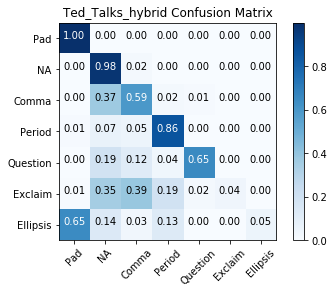

In [23]:
plot_confusion_matrix(hybrid_cm, 'Ted_Talks_hybrid', normalize=True)

****Normalized confusion matrix:****


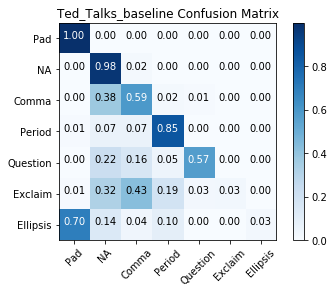

In [24]:
plot_confusion_matrix(baseline_cm, 'Ted_Talks_baseline', normalize=True)

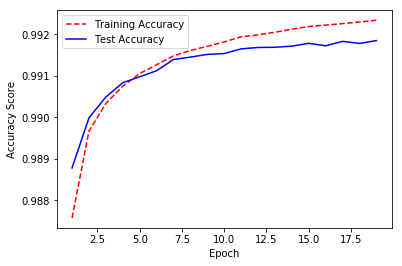

In [11]:
plot_train_hist(hybrid)

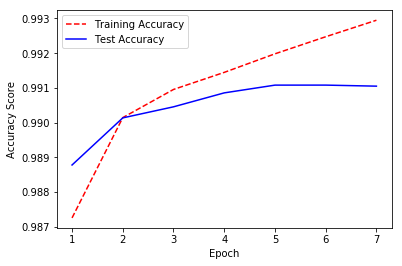

In [12]:
plot_train_hist(baseline)

[Return to results](#results)

##### <a name='mge'> MGE dataset Classification Reports and Confusion Matrices </a>

In [17]:
mge_df = get_df(mge_cr_d, 'mge')
mge_baseline_df = get_df(mge_baseline_cr_d, 'mge')
print('****MGE Hybrid vs Baseline****')
print(mge_df)
print('\n')
print(mge_baseline_df)

****MGE Hybrid vs Baseline****
              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  5982527
NA                 0.95    0.98      0.96  1075676
Period             0.64    0.72      0.68   108335
Comma              0.61    0.37      0.46    73320
Question           0.75    0.64      0.69    21937
Exclaim            0.45    0.12      0.19    13824
Ellipsis           0.46    0.08      0.14     6045
micro avg          0.98    0.98      0.98  7281664
macro avg          0.69    0.56      0.59  7281664
weighted avg       0.98    0.98      0.98  7281664


              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  5982527
NA                 0.95    0.98      0.96  1075676
Period             0.65    0.68      0.66   108335
Comma              0.56    0.39      0.46    73320
Question           0.72    0.61      0.66    21937
Exclaim            0.44    0.15      0.22    13824
Ellipsis           0.45    0.06      0.10     604

****Normalized confusion matrix:****


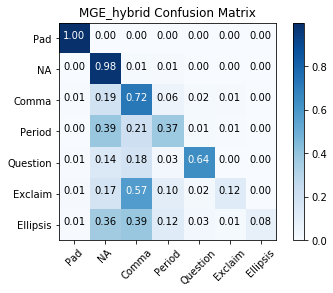

In [25]:
plot_confusion_matrix(mge_cm, 'MGE_hybrid', normalize=True)

****Normalized confusion matrix:****


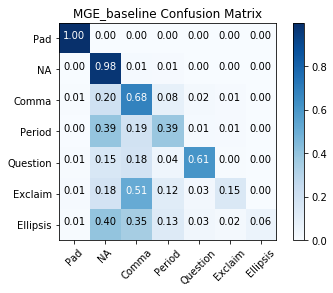

In [26]:
plot_confusion_matrix(mge_baseline_cm, 'MGE_baseline', normalize=True)

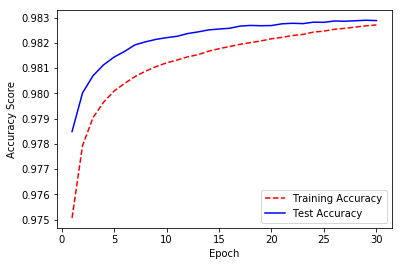

In [13]:
plot_train_hist(mge)

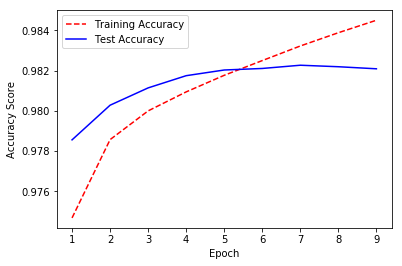

In [15]:
plot_train_hist(mge_baseline)

[Return to results](#results)

##### <a name='ted_train'> Ted Talks dataset Hybrid vs Hybrid_trainable Classification Reports and Confusion Matrices </a>

In [36]:
hybrid_df = get_df(hybrid_cr_d, 'hybrid')
hybrid_train_df = get_df(hybrid_train_cr_d, 'hybrid')
print('****Ted Talks Hybrid vs Ted Talks Hybrid Trainable****')
print(hybrid_df)
print('\n')
print(hybrid_train_df)

****Ted Talks Hybrid vs Ted Talks Hybrid Trainable****
              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  4931231
NA                 0.97    0.98      0.97  1014905
Comma              0.68    0.59      0.64    76089
Period             0.91    0.86      0.89    64139
Question           0.70    0.65      0.68     5522
Exclaim            0.24    0.04      0.07      566
Ellipsis           0.61    0.05      0.10      476
micro avg          0.99    0.99      0.99  6092928
macro avg          0.73    0.60      0.62  6092928
weighted avg       0.99    0.99      0.99  6092928


              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  4931231
NA                 0.97    0.97      0.97  1014905
Comma              0.64    0.62      0.63    76089
Period             0.90    0.87      0.88    64139
Question           0.66    0.62      0.64     5522
Exclaim            0.12    0.08      0.09      566
Ellipsis           0.91  

****Normalized confusion matrix:****


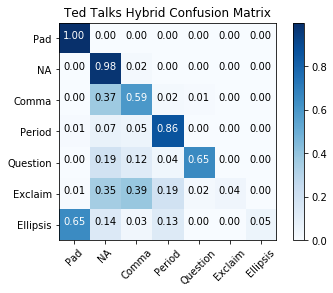

In [37]:
plot_confusion_matrix(hybrid_cm, 'Ted Talks Hybrid', normalize=True)

****Normalized confusion matrix:****


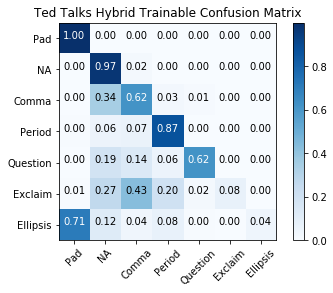

In [38]:
plot_confusion_matrix(hybrid_train_cm, 'Ted Talks Hybrid Trainable', normalize=True)

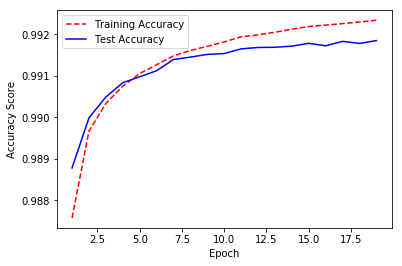

In [11]:
plot_train_hist(hybrid)

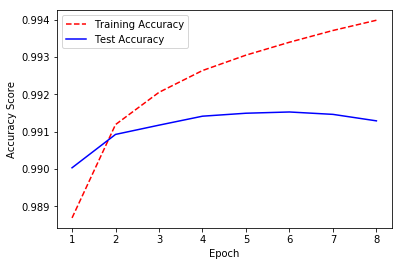

In [9]:
plot_train_hist(hybrid_train)

[Return to results](#results)

##### <a name='mge_train'> MGE dataset Hybrid vs Hybrid_trainable Classification Reports and Confusion Matrices </a>

In [39]:
mge_df = get_df(class_rept_dict=mge_cr_d, dataset_type='mge') 
mge_train_df = get_df(class_rept_dict=mge_train_cr_d, dataset_type='mge')
print('****MGE Hybrid vs MGE Hybrid Trainable****')
print(mge_df)
print('\n')
print(mge_train_df)

****MGE Hybrid vs MGE Hybrid Trainable****
              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  5982527
NA                 0.95    0.98      0.96  1075676
Period             0.64    0.72      0.68   108335
Comma              0.61    0.37      0.46    73320
Question           0.75    0.64      0.69    21937
Exclaim            0.45    0.12      0.19    13824
Ellipsis           0.46    0.08      0.14     6045
micro avg          0.98    0.98      0.98  7281664
macro avg          0.69    0.56      0.59  7281664
weighted avg       0.98    0.98      0.98  7281664


              precision  recall  f1-score  support
Pad                1.00    1.00      1.00  5982527
NA                 0.96    0.98      0.97  1075676
Period             0.67    0.74      0.70   108335
Comma              0.57    0.47      0.51    73320
Question           0.75    0.66      0.70    21937
Exclaim            0.48    0.15      0.23    13824
Ellipsis           0.47    0.08      

****Normalized confusion matrix:****


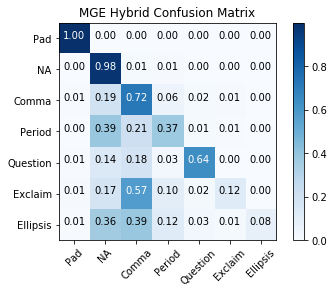

In [40]:
plot_confusion_matrix(mge_cm, 'MGE Hybrid', normalize=True)

****Normalized confusion matrix:****


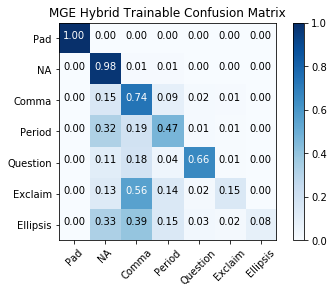

In [41]:
plot_confusion_matrix(mge_train_cm, 'MGE Hybrid Trainable', normalize=True)

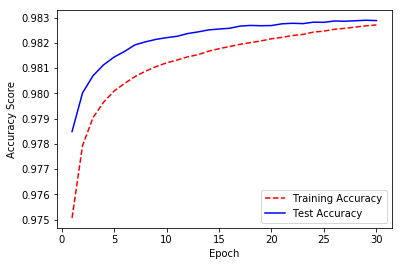

In [13]:
plot_train_hist(mge)

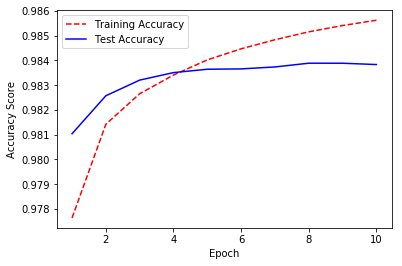

In [9]:
plot_train_hist(mge_train)

[Return to results](#results)

#### Make single predictions using testing data on each model

In [12]:
make_prediction(hybrid, test_x[3333], vocab_to_int, label_to_int, 'hybrid', show_process=True)

Predictions Index:
[array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]


Prediction sequence:
by the way i hope you appreciate the deep historical research i did to make the french look good but lets not exaggerate — its not archeology either but why because of cooperation <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

In [27]:
make_prediction(baseline, test_x[6666], vocab_to_int, label_to_int, 'baseline')

Combined prediction:
And in 2009, I had the opportunity to visit the tepui table mountains, which are in the orinoco and amazon basins.                                                                                                           


In [28]:
make_prediction(mge, mge_test_x[1111], mge_vocab_to_int, mge_label_to_int, 'mge')

Combined prediction:
Now let me think. Let me see. I know i'm going to take a towel with me. What will you take to the beach today? What will you take to the beach today?                                                                                               


#### <a name='improvements'> Future/Possible Improvements </a>
* Increase dataset size
* Add attention mechanism. Work in progress, [Reference Material](https://machinelearningmastery.com/attention-long-short-term-memory-recurrent-neural-networks/)
* Expand classes to predict names and locations. This could be done by processing the input data and adding NAME and LOC tokens to the label data before training

#### <a name='reference'> References </a>

* [Bitbucket Repo]()
* [How to build a PoS tagger](https://nlpforhackers.io/lstm-pos-tagger-keras/)
* [Keras pre-trained word embeddings](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
* [Keras Documentation](https://keras.io/)
* [Reference Repo](https://github.com/catcd/LSTM-CNN-SUD)